In [1]:
#include all necessary imports
from qiskit import *
%matplotlib inline
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

# Bernstein Vazirani Algorithm

Given a black-box function f:{0,1}n↦{0,1} (also called a Oracle), we are expected to find a string of bits s∈{0,1}n (a secret number). 

### Classical solution
The oracle returns: 𝑓𝑠(𝑥) = 𝑠 ⋅ 𝑥 mod 2
Given an input x, the hidden string s can be revealed by querying the oracle of n times, n is the number of bits. 

            1010 
     AND    0001
     ____________
            0000
Using the AND gate to figure out if each bit is 1. 

### Quantum Solution
By using the Bernstein Vazirani Algorithm we can find the hidden bit string with one call to the function.

1. Initailize the input qubits to |0⟩   and the output qubit to |-⟩  
2. Apply hadamard gates to the input registers
3. Query the Oracle
4. Apply Hadamard gates to the input registers
5. Measure


In [2]:
#Setting up a 4 bit Secret Number in binary
secretNumber = '1010'

In [3]:
#Setting up Quantum Circuit with n+1 qubits and n classic bits
circuit = QuantumCircuit(len(secretNumber)+1, len(secretNumber))

In [4]:
#Apply Hadamard gate on all qubits except the control bit
circuit.h(range(len(secretNumber)))

In [5]:
#Apply a X gate and a Hadamard gate on the control bit
circuit.x(len(secretNumber))
circuit.h(len(secretNumber))

In [6]:
#Apply barrier
circuit.barrier()

### Phase Oracle

In [7]:
#Applying CNOT gate at qubits that has 1 in secret number
for index, bit in enumerate(reversed(secretNumber)):
    if bit == '1':
        circuit.cx(index,len(secretNumber))

In [8]:
#Apply barrier
circuit.barrier()

In [9]:
#Apply Hadamard gate again on all qubits except the control bit
circuit.h(range(len(secretNumber)))

In [10]:
#Apply barrier
circuit.barrier()

In [11]:
#Measure all qubits except the control bit and send it to classic bits
circuit.measure(range(len(secretNumber)),range(len(secretNumber)))

### Circuit representation

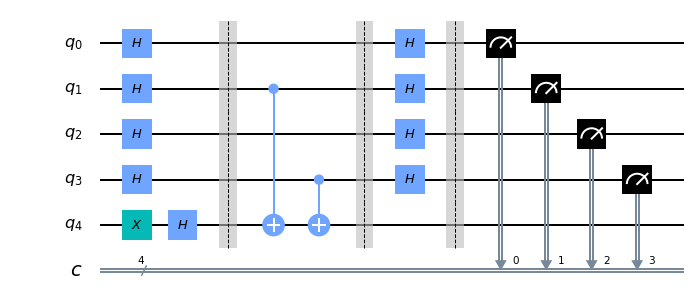

In [12]:
circuit.draw(output = 'mpl')

### Simulating the circuit

In [13]:
#Selecting the quantum assembly simulator
simulator = Aer.get_backend('qasm_simulator')

In [14]:
#Set shots to 1 because we know it will give us the correct answer in 1 try
shots = 1

In [15]:
#Executing the circuit in the simulator and saving the results
result = execute(circuit, backend = simulator, shots = 1).result()

In [16]:
#Printing out the secret number
counts = result.get_counts()
print(counts)

{'1010': 1}


'1010' is the correct secret number

### Running the circuit on Quantum Computer

In [17]:
#Selecting the qunatum computer from IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_16_melbourne')

In [18]:
#Executing the circuit on Quantum Computer with default 1024 shots
job = execute(circuit, backend = qcomp)
job_monitor(job)

Job Status: job has successfully run


In [19]:
#Printing out the result from Quantum Computer
result = job.result()
counts = result.get_counts()
max_key = max(counts, key=counts.get) #Getting the highest count
print(max_key)                        #as the secret number

1110


### Result Histogram

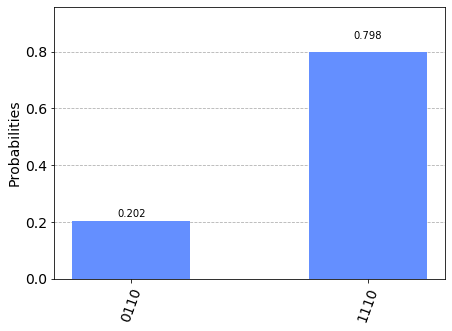

In [20]:
plot_histogram(result.get_counts(circuit))

The result is incorrect and the correct number did not even show up once because of the CNOT gates belong to the set of multiqubit operators and are difficult to engineered precisely.

### Alternative Circuit Design
The goal of the new circuit is to limit the contorl gates, so the more precise the outcome can be. 

Because the ancilla(control bit) stays constant throughout calculation, and it is only used for phase kick-back. As long as we can produce (−1)f(x)|x⟩ we can eliminate using an ancilla. The Z gate is able to reverse the sign, it keeps the state |0⟩ unchanged and transforms |1⟩ into −|1⟩. We can apply the z gate when f(x) = 1.

In [21]:
#Creates the alternative circuit for BV Algorithm
def alt_circuit(nQbuits, s):
    qc = QuantumCircuit(nQbuits,nQbuits)
    
    #Apply Hadamard gate on all qubits
    for i in range(nQubits):
        qc.h(i)
    qc.barrier()
    
    #Apply Z gate when bit is '1'
    for index, bit in enumerate(reversed(s)):
        if bit == '1':
            qc.z(index)
    qc.barrier()
    
    #Apply Hadamard gate on all qubits
    for i in range(nQubits):
        qc.h(i)
    qc.barrier()
    
    qc.measure(range(nQubits), range(nQubits))
    
    return qc

In [24]:
nQubits = 4
bvCircuit_alternative = alt_circuit(nQubits, secretNumber) 

Job Status: job has successfully run


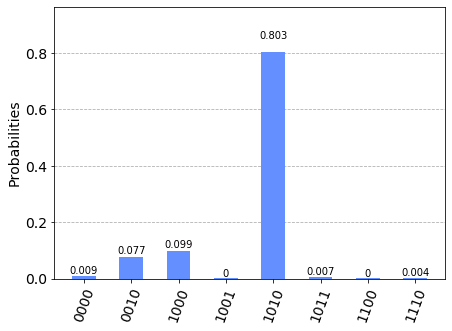

In [25]:
shots = 1024
job = execute(bvCircuit_alternative, backend=qcomp, shots=shots)
job_monitor(job)
result = job.result()
answer = result.get_counts()
plot_histogram(answer) 

The result give us around 80% of accuracy to guess the correct nunmber.